<span style="font-size:25px">___ATENCIÓN!!___ El presente documento se ha hecho con la intención de mostrar de alguna manera el trabajo que ha habido detrás de las decisiones finales tomadas. Sin embargo, el proceso no se ha llevado a cabo en el mismo orden en que se presenta el presente documento. Aunque en este _notebook_ se han llevado a cabo unas pocas iteraciones, la realidad es que se han hecho muchas más, tras las cuales normalmente se ha vuelto a la fase de análisis de datos y a intentar enriquecer los datos para mejorar los modelos.</span>

# Pruebas entrenamientos de modelos

En el presente documento se presentan las diferentes pruebas que se han hecho en para encontrar el modelo que mejores predicciones nos ofrezca a partir de los datos con los que contamos.

In [1]:
## Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Para el cálculo de distancias entre apartamentos y medios de transporte
from geopy.distance import distance
from decimal import *
## Librerías para el entrenamiento del modelo
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

In [2]:
# Importamos data set
df = pd.read_csv('../data/df_pruebas_modelos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12637 entries, 0 to 12636
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    12637 non-null  int64  
 1   neighbourhood_group_cleansed  12637 non-null  object 
 2   bathrooms                     12637 non-null  int64  
 3   bedrooms                      12637 non-null  int64  
 4   price                         12637 non-null  float64
 5   neighbourhood_scale           12637 non-null  float64
 6   neighbourhood_num             12637 non-null  int64  
 7   terraza                       12637 non-null  int64  
 8   balcon                        12637 non-null  int64  
 9   calefaccion                   12637 non-null  int64  
 10  pool                          12637 non-null  int64  
 11  garaje                        12637 non-null  int64  
 12  aire_acondicionado            12637 non-null  int64  
 13  a

## Modelo 1

En esta primera iteración, probaremos a entrenar modelos de regresión lineal con el total del _data-set_ para después comprobar el modelo que dé mejores resultados y ver cuáles son las variables que más afectan en las predicciones de __precio/noche__.

En primer lugar, dividimos el _data-set_ en 80% como conjunto de entrenamiento y 20% como conjunto de valización, dejando la variable _price_ como _target_.

In [3]:
target = "price"
y,X =df[target], df.drop(target,axis="columns")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.20, random_state=42)

Normalizamos el DS utilizando _StandardScaler_ y convertimos las variables no-numérica en variables numéricas con _OneHotEncoder_.

In [4]:
numerical_features = X.select_dtypes(exclude='object').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

### Elección del modelo

Para la obtención de predicciones de __precio/noche__ tenemos claro que es necesario utilizar modelos de regresión dado que permiten modelar la relación entre diferentes variables que pueden ser tanto dependientes como independientes. Además, son modelos fáciles de interpretar, pudiendo entender cómo han obtenido sus resultados, siendo capaces así de poder optimizar sus hiperparámetros de forma lógica y sabiendo lo que hace cada uno de ellos.

Dado que existen infinidad de modelos de regresión que se podrían aplicar para el presente problema, hemos decidido hacer pruebas con 8 modelos que utilizan métodos y enfoques diferentes:

- __Regresión Lineal__: hemos querido empezar con un modelo sencillo que, aunque de primeras podemos esperar que no será el más preciso, es muy útil como punto de partida para poder comparar los resultados del resto de modelos con los de este.
- __Descenso de Gradientes Estocásticos (SGD)__: este método hemos querido añadirlo a las pruebas con la idea de utilizar un modelo en que se aplique una regresión estocástica.
- __Ridge__ y __Lasso__: son otros de lo modelos más típicos para este tipo de problemas, los cuales se diferencian entre sí por cómo aplican las penalizaciones sobre las predicciones para obtener sus resultados.
- __Elastic Net__: este método se utiliza con la idea de utilizar en un mismo modelo una mezcla entre lo dos anteriores, partiendo de un valor de _alpha_ = 0.5 para que el modelo quede a mitad de camino entre los 2 métdos anteriores.
- __Huber Regression__: aunque hemos hecho una limpieza de _outliers_, es posible que no haya sido lo suficientemente exaustiva dado que pueden existir errores dentro del _data-set_ de AirBnB de los que no somos conscientes. Es por eso que hemos querido utilizar un modelo robusto como este, el cual funciona muy bien con _data-sets_ con existencia de _outliers_.
- __*Suport Vector Regression*__: también queríamos comprobar el comportamiento que tienen las máquinas de vectores de soporte. Y es por eso que hemos optado por esta regresión lineal basada en una SVM
- __*Extreme Gradient Boosting Regressor*__: por último, también hemos querido probar con un método basado en árboles de decisión. Y aunque sabemos que el _XGBoost Regresssor_ está más pensado para _data-sets_ de grandes dimensiones, hemos pensado que este potente método podría obtener unos mejores resultados que otras posibles opciones.

En cuanto a las métricas que hemos utilizado para comprobar la precisión de los diferentes modelos, hemos calculado las siguientes:

- __R cuadrada (R2)__: esta se ha utilizado con la idea de entender cómo afectan las variables independientes a los resultados de la regresión.
- __Error Medio Cuadrado (MSE)__: esta se ha estudiado debido a su capacidad de pendalizar los errores más grandes en las predicciones.
- __Raíz del Error Medio Cuadrado (RMSE)__: con esta métrica se ha querido hacer el mismo estudio que la anterior pero viéndolo con las unidades originales de los precios predichos. 
- __Porcentaje de Error Medio Absoluto (MAPE)__: con esta métrica, lo que hemos buscado es poder medir la precisión de las predicciones en forma de porcentaje de forma que sea fácilmente interpretable. Por esa misma razón, esta métrica es en la que más nos hemos fijado, siempre vigilando en caso de que no nos ofrezca valores no definidos.

Así pues, hacemos a continuación las comprobaciones pertinentes.

In [5]:
models = {
    'LinearRegression': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', LinearRegression())]),
    'Ridge': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', Ridge(alpha=1, random_state=42))]),
    'Lasso': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', Lasso(alpha=1, random_state=42))]),
    'SGD': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', SGDRegressor(alpha=0.0001, max_iter=1000, random_state=42))]),
    'HuberRegressor': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', HuberRegressor(alpha=0.0001, max_iter=100, epsilon=1.35))]),
    'ElasticNet': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', ElasticNet(alpha=1, l1_ratio=0.5, random_state=42))]),
    'XGBRegressor': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))]),
    'SVR': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', SVR(kernel='linear'))])
}

def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
        df_metrics_analysis = pd.DataFrame(metrics_analysis).sort_values('mape')
    return df_metrics_analysis

In [6]:
get_results(X_train, y_train, X_test, y_test)

 38%|███▊      | 3/8 [00:00<00:00, 11.04it/s]c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


,r2,mse,rmse,mape
SVR,0.405240,1292.459770,35.950797,0.240057
HuberRegressor,0.413213,1275.133593,35.709013,0.242677
XGBRegressor,0.460291,1172.829852,34.246604,0.245609
LinearRegression,0.414745,1271.805403,35.662381,0.255940
Ridge,0.414704,1271.894379,35.663628,0.255968
SGD,0.406451,1289.828966,35.914189,0.259882
Lasso,0.390217,1325.105703,36.402001,0.268854
ElasticNet,0.374379,1359.523097,36.871711,0.276899


Después de una primera iteración con hiperparámetros estandar en cada uno de los modelos, podemos observar que, en general, los modelos que mejores predicciones han ofrecido han sido los sigientes:
- __*Suport Vector Regression* (SVR)__
- __*Huber Regressor*__
- __*Extreme Gradient Boosting Regressor* (XGBRegressor)__

Optimicemos los hiperparámetros de cada uno de los modelos anteriores a ver cuál es el que realmente ofrece mejores resultados.

#### Optimización de hiperparámetros del _SVR_

In [7]:
param_grid_SVR = {
    'regressor__C': [0.1, 1.0, 10.0],
    'regressor__epsilon': [0.1, 0.2, 0.3]
}

pipe_SVR = models['SVR']

grid_search_SVR = GridSearchCV(pipe_SVR, param_grid_SVR, verbose=1)
grid_search_SVR.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Unnamed: '
                                                                          '0',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'neighbourhood_scale',
                                                                          'neighbourhood_num',
                                                                          'terraza',
                                                                          'balcon',
                                                                          'calefaccion',
                                                                          'pool',
                                                                          'garaje',
                                                                          'aire_acondicionado',
                                                                          'ascensor',
                                                                          'movilidad_reducida',
                                                                          'distance_to_center',
                                                                          'distance_to...
                                                                          'distance_to_atocha',
                                                                          'distance_to_chamartin',
                                                                          'DISTANCE_TO_METRO',
                                                                          'DISTANCE_TO_CERCANIAS',
                                                                          'DISTANCE_TO_EMT',
                                                                          'DISTANCE_TO_INTERURBANOS',
                                                                          'DISTANCE_TO_MLO']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['neighbourhood_group_cleansed',
                                                                          'renta_bin'])])),
                                       ('regressor', SVR(kernel='linear'))]),
             param_grid={'regressor__C': [0.1, 1.0, 10.0],
                         'regressor__epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

In [8]:
model_SVR = grid_search_SVR.best_estimator_
y_test_pred_SVR = model_SVR.predict(X_test)
y_train_pred_SVR = model_SVR.predict(X_train)

Veamos los errores que tienen las predicciones del método _SVR_ después de haber optimizado sus hiperparámetros.

Primero con el __conjunto de entrenamiento__:

In [9]:
mse = mean_squared_error(y_train, y_train_pred_SVR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred_SVR)
r2 = r2_score(y_train, y_train_pred_SVR)
SVR_train = pd.Series(name='SVR_train', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4021540871774172 mse: 1377.7481388788979 rmse: 37.11802983563241 mape: 0.23941926712645795


Después con el __conjunto de prueba__:

In [10]:
mse = mean_squared_error(y_test, y_test_pred_SVR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred_SVR)
r2 = r2_score(y_test, y_test_pred_SVR)
SVR_test = pd.Series(name='SVR_test', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4072983704665818 mse: 1287.9868894030715 rmse: 35.88853423313735 mape: 0.23931709933774625


#### Optimización de hiperparámetros del _Huber Regressor_

In [11]:
param_grid_HR = {
    'regressor__epsilon': [1.1, 1.35, 1.5],
    'regressor__alpha': [0.0001, 0.001, 0.01]
}

pipe_HR = models['HuberRegressor']

grid_search_HR = GridSearchCV(pipe_HR, param_grid_HR, verbose=1)
grid_search_HR.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Unnamed: '
                                                                          '0',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'neighbourhood_scale',
                                                                          'neighbourhood_num',
                                                                          'terraza',
                                                                          'balcon',
                                                                          'calefaccion',
                                                                          'pool',
                                                                          'garaje',
                                                                          'aire_acondicionado',
                                                                          'ascensor',
                                                                          'movilidad_reducida',
                                                                          'distance_to_center',
                                                                          'distance_to...
                                                                          'distance_to_atocha',
                                                                          'distance_to_chamartin',
                                                                          'DISTANCE_TO_METRO',
                                                                          'DISTANCE_TO_CERCANIAS',
                                                                          'DISTANCE_TO_EMT',
                                                                          'DISTANCE_TO_INTERURBANOS',
                                                                          'DISTANCE_TO_MLO']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['neighbourhood_group_cleansed',
                                                                          'renta_bin'])])),
                                       ('regressor', HuberRegressor())]),
             param_grid={'regressor__alpha': [0.0001, 0.001, 0.01],
                         'regressor__epsilon': [1.1, 1.35, 1.5]},
             verbose=1)

In [12]:
model_HR = grid_search_HR.best_estimator_
y_test_pred_HR = model_HR.predict(X_test)
y_train_pred_HR = model_HR.predict(X_train)

Veamos los errores que tienen las predicciones del método _Huber Regressor_ después de haber optimizado sus hiperparámetros.

Primero con el __conjunto de entrenamiento__:

In [13]:
mse = mean_squared_error(y_train, y_train_pred_HR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred_HR)
r2 = r2_score(y_train, y_train_pred_HR)
HR_train = pd.Series(name='HR_train', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.41051886266078785 mse: 1358.4713426222447 rmse: 36.857446230337835 mape: 0.2442285300341455


Después con el __conjunto de prueba__:

In [14]:
mse = mean_squared_error(y_test, y_test_pred_HR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred_HR)
r2 = r2_score(y_test, y_test_pred_HR)
HR_test = pd.Series(name='HR_test', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4186830623948199 mse: 1263.2470654970587 rmse: 35.54218712315069 mape: 0.24302076408329168


#### Optimización de hiperparámetros del _XGB Regressor_

In [15]:
param_grid_XGBR = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [4, 6, 8],
    'regressor__learning_rate': [0.05, 0.1, 0.2]
}

pipe_XGBR = models['XGBRegressor']

grid_search_XGBR = GridSearchCV(pipe_XGBR, param_grid_XGBR, verbose=1)
grid_search_XGBR.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Unnamed: '
                                                                          '0',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'neighbourhood_scale',
                                                                          'neighbourhood_num',
                                                                          'terraza',
                                                                          'balcon',
                                                                          'calefaccion',
                                                                          'pool',
                                                                          'garaje',
                                                                          'aire_acondicionado',
                                                                          'ascensor',
                                                                          'movilidad_reducida',
                                                                          'distance_to_center',
                                                                          'distance_to...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=6,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__learning_rate': [0.05, 0.1, 0.2],
                         'regressor__max_depth': [4, 6, 8],
                         'regressor__n_estimators': [50, 100]},
             verbose=1)

In [16]:
model_XGBR = grid_search_XGBR.best_estimator_
y_test_pred_XGBR = model_XGBR.predict(X_test)
y_train_pred_XGBR = model_XGBR.predict(X_train)

Veamos los errores que tienen las predicciones del método _XGB Regressor_ después de haber optimizado sus hiperparámetros.

Primero con el __conjunto de entrenamiento__:

In [17]:
mse = mean_squared_error(y_train, y_train_pred_XGBR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred_XGBR)
r2 = r2_score(y_train, y_train_pred_XGBR)
XGBR_train = pd.Series(name='XGBR_train', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4788968191035372 mse: 1200.8929428895071 rmse: 34.65390227506142 mape: 0.24140475543518303


Después con el __conjunto de prueba__:

In [18]:
mse = mean_squared_error(y_test, y_test_pred_XGBR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred_XGBR)
r2 = r2_score(y_test, y_test_pred_XGBR)
XGBR_test = pd.Series(name='XGBR_test', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.48994401260328047 mse: 1108.3914602118919 rmse: 33.29251357605628 mape: 0.24220050412469132


#### Comparación de resultados

Comparemos los resultados obtenido de los 3 modelos después de haber optimizado los hiperparámetros de todos ellos.

In [19]:
results = pd.DataFrame([SVR_train, SVR_test, HR_train, HR_test, XGBR_train, XGBR_test])

In [20]:
results

,R2,MSE,RMSE,MAPE
SVR_train,0.402154,1377.748139,37.118030,0.239419
SVR_test,0.407298,1287.986889,35.888534,0.239317
HR_train,0.410519,1358.471343,36.857446,0.244229
HR_test,0.418683,1263.247065,35.542187,0.243021
XGBR_train,0.478897,1200.892943,34.653902,0.241405
XGBR_test,0.489944,1108.391460,33.292514,0.242201


Como se puede obesrvar en la tabla resumen, el modelo que mejor reultado ha ofrecido (sobre todo fijándonos en los resultados del _Mean Absolute Percentage Error_) es que el método del __SVR__ es el que ofrece mejores reultados, tanto con el conjunto de entrenamiento como con el conjunto de prueba. Así que utilizaremos este modelo con lo hiperparámetros optimizados.

### Estudio de los resultados

Estudiemos ahora los resultados de las predicciones.

In [21]:
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred_SVR})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred_SVR})

In [22]:
test_predict_analysis["y_pred_diff"]=test_predict_analysis["y_pred"]-test_predict_analysis["y"]

Text(0, 0.5, 'Diferencia entre precio predicho y precio real')

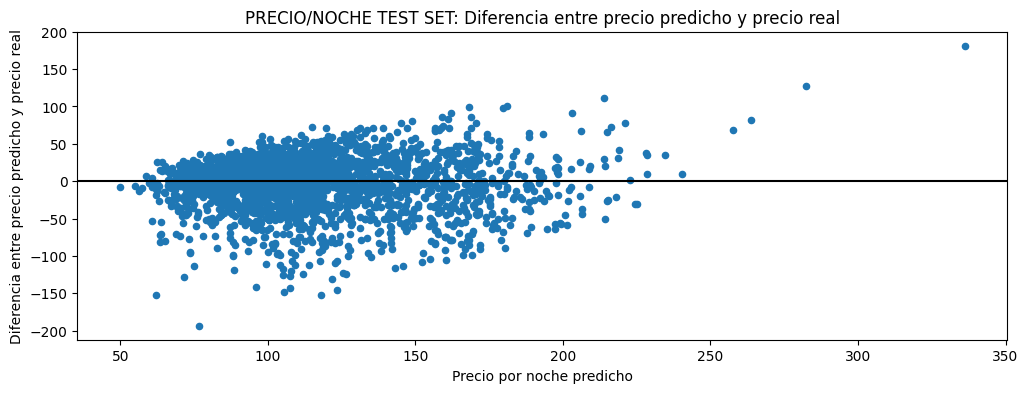

In [23]:
_,ax = plt.subplots(figsize=(12,4))
test_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")
ax.set_title('PRECIO/NOCHE TEST SET: Diferencia entre precio predicho y precio real')
ax.set_xlabel("Precio por noche predicho")
ax.set_ylabel("Diferencia entre precio predicho y precio real")

Comprobemos ahora cuáles son las variables que más han afectado a la predicción de los __precios/noche__.

In [24]:
# Obtenemos los nombres de columnas transformadas:
# Para numéricas, los nombres se mantienen
num_names = numerical_features

# Para categóricas, necesitamos obtenerlos desde el OneHotEncoder
cat_names = model_SVR.named_steps["preprocessor"].named_transformers_['cat'].get_feature_names_out(categorical_features)

# # Combinamos ambos
all_feature_names = list(num_names) + list(cat_names)

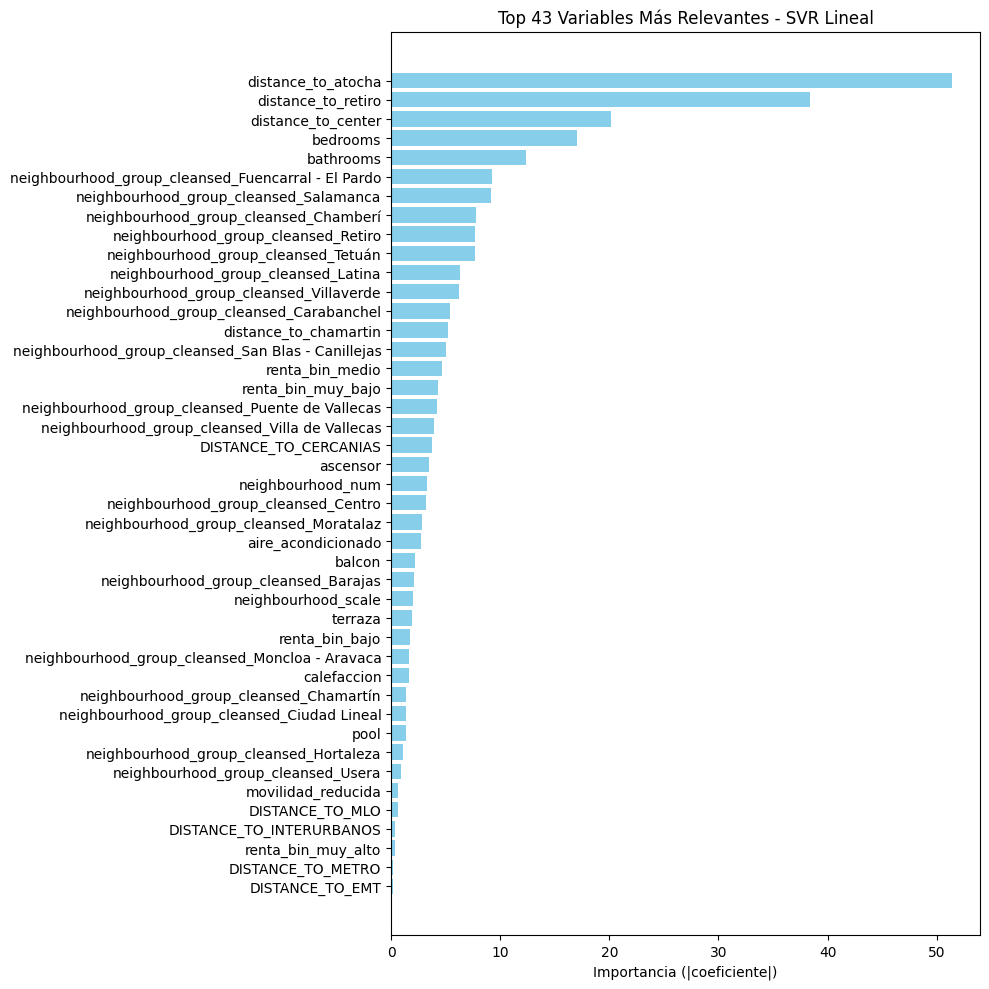

In [25]:
# Extraer los coeficientes absolutos
coeficientes = np.abs(model_SVR.named_steps['regressor'].coef_[0])

# Asociar coeficientes con nombres de variables
importancias_df = pd.DataFrame({
    'Variable': all_feature_names,
    'Importancia': coeficientes
}).sort_values(by='Importancia', ascending=False)

# Opcional: filtrar top N variables más importantes
top_n = 43
importancias_top = importancias_df.head(top_n)

# Graficar
plt.figure(figsize=(10, 10))
plt.barh(importancias_top['Variable'], importancias_top['Importancia'], color='skyblue')
plt.gca().invert_yaxis()  # Las más importantes arriba
plt.xlabel('Importancia (|coeficiente|)')
plt.title(f'Top {top_n} Variables Más Relevantes - SVR Lineal')
plt.tight_layout()
plt.show()

Del gráfico anterior se pueden obtener diferentes conclusiones y, en muchos casos, que ya habíamos supuesto en hipótesis iniciales.

Por un lado, se ve que, de los datos referentes a los apartamentos y lo que estos incluyen, los factoress más relevantes (como era de esperar) son la cantidad de habitaciones y de baños. Esto tiene sentido porque son datos esenciales en los que __siempre__ se fijan los usuarios a la hora de buscar un apartamento turístico, por lo que los precios estarán fuertemente influenciados por estas variables.

Por otro lado, es evidente que la localización de los apartamentos es primordial para la predicción de lo precios. Sobre todo dónde se encuentren los apartamentos en relación con Puerta del Sol, Parque del Retiro y la estación de Atocha.

También tiene gran relevancia el ditrito en el que se encuentreen los apartamentos. En este sentido, se han representado de 3 formas diferentes la información referente a los distritos en los que se encuentran las viviendas:
- Tal como aparecía en el _data-set_ inicial de AirBnB. En este caso hay que procesarlo mediante _One Hot Encoder_ para pasarlo a valores numéricos
- Según una escala del 0 al 1 en función de los __precios medios/noche__ de cada uno de los distritos
- Según una escala del 1 al 21 también en función de los __precios medios/noche__ de cada uno de los distritos

En este sentido, la conclusión a la que se puede llegar es que es más lógico y ofrece más información al modelo dejar estos datos tal y como venían en el _data-set_ original, procesándolos con _One Hot Encoder_ antes de entrenar el modelo. Sobre todo porque se ha comprobado que de esta forma no se tiende al _over-fitting_ de los resultados que hubiera sido la principal razón por la que representar los datos de los distritos de forma diferentes sin necesidad de dicho procesamiento.

También es interesante comentar que las __rentas medias netas por hogar__ también han tenido un papel relevante en las predicciones de los precios.

Por último, cabe destacar que, de las distancias a las paradas de diferentes medios de transporte públicos, tal y como ya habíamos podido observar en el análisis de dichos datos, es la distancia a paradas de cercanías las que más pueden afectar a los __precios/noche__ de los apartamentos.

## Modelo 2

En esta segunda iteración, teniedo en cuenta los resultados obtenidos en la primera, lo que cambiaremos simplemente es el _data-set_.

In [26]:
df = pd.read_csv('../data/df_pruebas_modelos.csv')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12637 entries, 0 to 12636
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    12637 non-null  int64  
 1   neighbourhood_group_cleansed  12637 non-null  object 
 2   bathrooms                     12637 non-null  int64  
 3   bedrooms                      12637 non-null  int64  
 4   price                         12637 non-null  float64
 5   neighbourhood_scale           12637 non-null  float64
 6   neighbourhood_num             12637 non-null  int64  
 7   terraza                       12637 non-null  int64  
 8   balcon                        12637 non-null  int64  
 9   calefaccion                   12637 non-null  int64  
 10  pool                          12637 non-null  int64  
 11  garaje                        12637 non-null  int64  
 12  aire_acondicionado            12637 non-null  int64  
 13  a

Borramos las variables que son innecesarias de los distritos y comprobamos que nos dé resultados, por lo menos, parecidos.
<a id="conclusiones"></a>

In [28]:
# Importamos data set
df = pd.read_csv('../data/df_pruebas_modelos.csv')
drop_cols = ['Unnamed: 0', 'neighbourhood_scale', 'neighbourhood_num']
df = df.drop(drop_cols, axis='columns')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12637 entries, 0 to 12636
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12637 non-null  object 
 1   bathrooms                     12637 non-null  int64  
 2   bedrooms                      12637 non-null  int64  
 3   price                         12637 non-null  float64
 4   terraza                       12637 non-null  int64  
 5   balcon                        12637 non-null  int64  
 6   calefaccion                   12637 non-null  int64  
 7   pool                          12637 non-null  int64  
 8   garaje                        12637 non-null  int64  
 9   aire_acondicionado            12637 non-null  int64  
 10  ascensor                      12637 non-null  int64  
 11  movilidad_reducida            12637 non-null  int64  
 12  distance_to_center            12637 non-null  float64
 13  d

En primer lugar, dividimos el _data-set_ en 80% como conjunto de entrenamiento y 20% como conjunto de valización, dejando la variable _price_ como _target_.

In [29]:
target = "price"
y,X =df[target], df.drop(target,axis="columns")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.20, random_state=42)

Normalizamos el DS utilizando _StandardScaler_ y convertimos las variables no-numérica en variables numéricas con _OneHotEncoder_.

In [30]:
numerical_features = X.select_dtypes(exclude='object').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

### Elección del modelo

Seguimos la misma lógica que en la primera iteración. 

Aunque en esencia sea el mismo _data-set_ con el que se deberían obtener las predicciones más precisas con el mismo modelo y los mismo hiperparámetros que en la primera iteración, volveremos a hacer todo el proceso para asegurarnos. Porque, al fin y al cabo, hemos hecho pequeños cambios dentro del _data-set_ que podrían suponer resultados diferentes.

In [31]:
models = {
    'LinearRegression': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', LinearRegression())]),
    'Ridge': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', Ridge(alpha=1, random_state=42))]),
    'Lasso': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', Lasso(alpha=1, random_state=42))]),
    'SGD': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', SGDRegressor(alpha=0.0001, max_iter=1000, random_state=42))]),
    'HuberRegressor': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', HuberRegressor(alpha=0.0001, max_iter=100, epsilon=1.35))]),
    'ElasticNet': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', ElasticNet(alpha=1, l1_ratio=0.5, random_state=42))]),
    'XGBRegressor': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))]),
    'SVR': Pipeline([('preprocessor', preprocessor),
                                  ('regressor', SVR(kernel='linear'))])
}

def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
        df_metrics_analysis = pd.DataFrame(metrics_analysis).sort_values('mape')
    return df_metrics_analysis

In [32]:
get_results(X_train, y_train, X_test, y_test)

 50%|█████     | 4/8 [00:00<00:00, 12.57it/s]c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


,r2,mse,rmse,mape
SVR,0.405024,1292.928788,35.957319,0.240018
HuberRegressor,0.413377,1274.777136,35.704021,0.242638
XGBRegressor,0.461896,1169.342878,34.195656,0.245458
SGD,0.412725,1276.193972,35.723857,0.255071
LinearRegression,0.414997,1271.258066,35.654706,0.255868
Ridge,0.414956,1271.346789,35.655950,0.255897
Lasso,0.390974,1323.460184,36.379392,0.269243
ElasticNet,0.374587,1359.071232,36.865583,0.277658


Después de una primera iteración con hiperparámetros estandar en cada uno de los modelos, volvemos a ver que, en general, los modelos que mejores predicciones han ofrecido han sido los sigientes:
- __*Suport Vector Regression* (SVR)__
- __*Huber Regressor*__
- __*Extreme Gradient Boosting Regressor* (XGBRegressor)__

Optimicemos los hiperparámetros de cada uno de los modelos anteriores a ver cuál es el que realmente ofrece mejores resultados.

#### Optimización de hiperparámetros del _SVR_

In [33]:
param_grid_SVR = {
    'regressor__C': [0.1, 1.0, 10.0],
    'regressor__epsilon': [0.1, 0.2, 0.3]
}

pipe_SVR = models['SVR']

grid_search_SVR = GridSearchCV(pipe_SVR, param_grid_SVR, verbose=1)
grid_search_SVR.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bathrooms',
                                                                          'bedrooms',
                                                                          'terraza',
                                                                          'balcon',
                                                                          'calefaccion',
                                                                          'pool',
                                                                          'garaje',
                                                                          'aire_acondicionado',
                                                                          'ascensor',
                                                                          'movilidad_reducida',
                                                                          'distance_to_center',
                                                                          'distance_to_retiro',
                                                                          'distance_to_atocha',
                                                                          'distance_to_chamartin',
                                                                          'DISTANCE_TO_METRO',
                                                                          'DISTANCE_TO_CERCANIAS',
                                                                          'DISTANCE_TO_EMT',
                                                                          'DISTANCE_TO_INTERURBANOS',
                                                                          'DISTANCE_TO_MLO']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['neighbourhood_group_cleansed',
                                                                          'renta_bin'])])),
                                       ('regressor', SVR(kernel='linear'))]),
             param_grid={'regressor__C': [0.1, 1.0, 10.0],
                         'regressor__epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

In [34]:
model_SVR = grid_search_SVR.best_estimator_
y_test_pred_SVR = model_SVR.predict(X_test)
y_train_pred_SVR = model_SVR.predict(X_train)

Veamos los errores que tienen las predicciones del método _SVR_ después de haber optimizado sus hiperparámetros.

Primero con el __conjunto de entrenamiento__:

In [35]:
mse = mean_squared_error(y_train, y_train_pred_SVR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred_SVR)
r2 = r2_score(y_train, y_train_pred_SVR)
SVR_train = pd.Series(name='SVR_train', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4022414515188696 mse: 1377.546805966422 rmse: 37.1153176729827 mape: 0.23944536203834027


Después con el __conjunto de prueba__:

In [36]:
mse = mean_squared_error(y_test, y_test_pred_SVR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred_SVR)
r2 = r2_score(y_test, y_test_pred_SVR)
SVR_test = pd.Series(name='SVR_test', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4073931436690209 mse: 1287.7809398390314 rmse: 35.885664823701276 mape: 0.23931663507424203


#### Optimización de hiperparámetros del _Huber Regressor_

In [37]:
param_grid_HR = {
    'regressor__epsilon': [1.1, 1.35, 1.5],
    'regressor__alpha': [0.0001, 0.001, 0.01]
}

pipe_HR = models['HuberRegressor']

grid_search_HR = GridSearchCV(pipe_HR, param_grid_HR, verbose=1)
grid_search_HR.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bathrooms',
                                                                          'bedrooms',
                                                                          'terraza',
                                                                          'balcon',
                                                                          'calefaccion',
                                                                          'pool',
                                                                          'garaje',
                                                                          'aire_acondicionado',
                                                                          'ascensor',
                                                                          'movilidad_reducida',
                                                                          'distance_to_center',
                                                                          'distance_to_retiro',
                                                                          'distance_to_atocha',
                                                                          'distance_to_chamartin',
                                                                          'DISTANCE_TO_METRO',
                                                                          'DISTANCE_TO_CERCANIAS',
                                                                          'DISTANCE_TO_EMT',
                                                                          'DISTANCE_TO_INTERURBANOS',
                                                                          'DISTANCE_TO_MLO']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['neighbourhood_group_cleansed',
                                                                          'renta_bin'])])),
                                       ('regressor', HuberRegressor())]),
             param_grid={'regressor__alpha': [0.0001, 0.001, 0.01],
                         'regressor__epsilon': [1.1, 1.35, 1.5]},
             verbose=1)

In [38]:
model_HR = grid_search_HR.best_estimator_
y_test_pred_HR = model_HR.predict(X_test)
y_train_pred_HR = model_HR.predict(X_train)

Veamos los errores que tienen las predicciones del método _Huber Regressor_ después de haber optimizado sus hiperparámetros.

Primero con el __conjunto de entrenamiento__:

In [39]:
mse = mean_squared_error(y_train, y_train_pred_HR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred_HR)
r2 = r2_score(y_train, y_train_pred_HR)
HR_train = pd.Series(name='HR_train', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.410526937270722 mse: 1358.4527345184335 rmse: 36.85719379603436 mape: 0.24422381873402996


Después con el __conjunto de prueba__:

In [40]:
mse = mean_squared_error(y_test, y_test_pred_HR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred_HR)
r2 = r2_score(y_test, y_test_pred_HR)
HR_test = pd.Series(name='HR_test', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4185782977172584 mse: 1263.4747273161731 rmse: 35.54538967737128 mape: 0.24304577584452758


#### Optimización de hiperparámetros del _XGB Regressor_

In [41]:
param_grid_XGBR = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [4, 6, 8],
    'regressor__learning_rate': [0.05, 0.1, 0.2]
}

pipe_XGBR = models['XGBRegressor']

grid_search_XGBR = GridSearchCV(pipe_XGBR, param_grid_XGBR, verbose=1)
grid_search_XGBR.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bathrooms',
                                                                          'bedrooms',
                                                                          'terraza',
                                                                          'balcon',
                                                                          'calefaccion',
                                                                          'pool',
                                                                          'garaje',
                                                                          'aire_acondicionado',
                                                                          'ascensor',
                                                                          'movilidad_reducida',
                                                                          'distance_to_center',
                                                                          'distance_to_retiro',
                                                                          'distance_to_atocha',
                                                                          'distance_to_chamartin',
                                                                          'D...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=6,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__learning_rate': [0.05, 0.1, 0.2],
                         'regressor__max_depth': [4, 6, 8],
                         'regressor__n_estimators': [50, 100]},
             verbose=1)

In [42]:
model_XGBR = grid_search_XGBR.best_estimator_
y_test_pred_XGBR = model_XGBR.predict(X_test)
y_train_pred_XGBR = model_XGBR.predict(X_train)

Veamos los errores que tienen las predicciones del método _XGB Regressor_ después de haber optimizado sus hiperparámetros.

Primero con el __conjunto de entrenamiento__:

In [43]:
mse = mean_squared_error(y_train, y_train_pred_XGBR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred_XGBR)
r2 = r2_score(y_train, y_train_pred_XGBR)
XGBR_train = pd.Series(name='XGBR_train', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4762809447861266 mse: 1206.9212787784961 rmse: 34.740772570259516 mape: 0.24227021236498808


Después con el __conjunto de prueba__:

In [44]:
mse = mean_squared_error(y_test, y_test_pred_XGBR)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred_XGBR)
r2 = r2_score(y_test, y_test_pred_XGBR)
XGBR_test = pd.Series(name='XGBR_test', data={'R2':r2, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape})
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.48723786547841685 mse: 1114.2721290745098 rmse: 33.380714927552255 mape: 0.24281248474922262


#### Comparación de resultados

Comparemos los resultados obtenido de los 3 modelos después de haber optimizado los hiperparámetros de todos ellos.

In [45]:
results = pd.DataFrame([SVR_train, SVR_test, HR_train, HR_test, XGBR_train, XGBR_test])

In [46]:
results

,R2,MSE,RMSE,MAPE
SVR_train,0.402241,1377.546806,37.115318,0.239445
SVR_test,0.407393,1287.780940,35.885665,0.239317
HR_train,0.410527,1358.452735,36.857194,0.244224
HR_test,0.418578,1263.474727,35.545390,0.243046
XGBR_train,0.476281,1206.921279,34.740773,0.242270
XGBR_test,0.487238,1114.272129,33.380715,0.242812


Como era de esperar, ocurre lo mismo que en la primera iteración. El modelo que mejor reultado ha ofrecido (sobre todo fijándonos en los resultados del _Mean Absolute Percentage Error_) es que el método del __SVR__ es el que ofrece mejores reultados, tanto con el conjunto de entrenamiento como con el conjunto de prueba. Así que utilizaremos este modelo con lo hiperparámetros optimizados.

### Estudio de los resultados

Estudiemos ahora los resultados de las predicciones.

In [47]:
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred_SVR})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred_SVR})

In [48]:
test_predict_analysis["y_pred_diff"]=test_predict_analysis["y_pred"]-test_predict_analysis["y"]

Text(0, 0.5, 'Diferencia entre precio predicho y precio real')

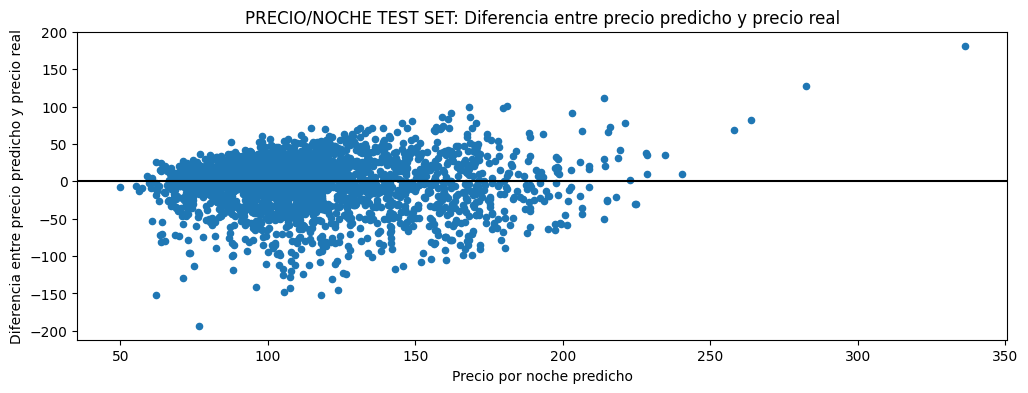

In [49]:
_,ax = plt.subplots(figsize=(12,4))
test_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")
ax.set_title('PRECIO/NOCHE TEST SET: Diferencia entre precio predicho y precio real')
ax.set_xlabel("Precio por noche predicho")
ax.set_ylabel("Diferencia entre precio predicho y precio real")

Comprobemos ahora cuáles son las variables que más han afectado a la predicción de los __precios/noche__.

In [50]:
# Obtenemos los nombres de columnas transformadas:
# Para numéricas, los nombres se mantienen
num_names = numerical_features

# Para categóricas, necesitamos obtenerlos desde el OneHotEncoder
cat_names = model_SVR.named_steps["preprocessor"].named_transformers_['cat'].get_feature_names_out(categorical_features)

# # Combinamos ambos
all_feature_names = list(num_names) + list(cat_names)

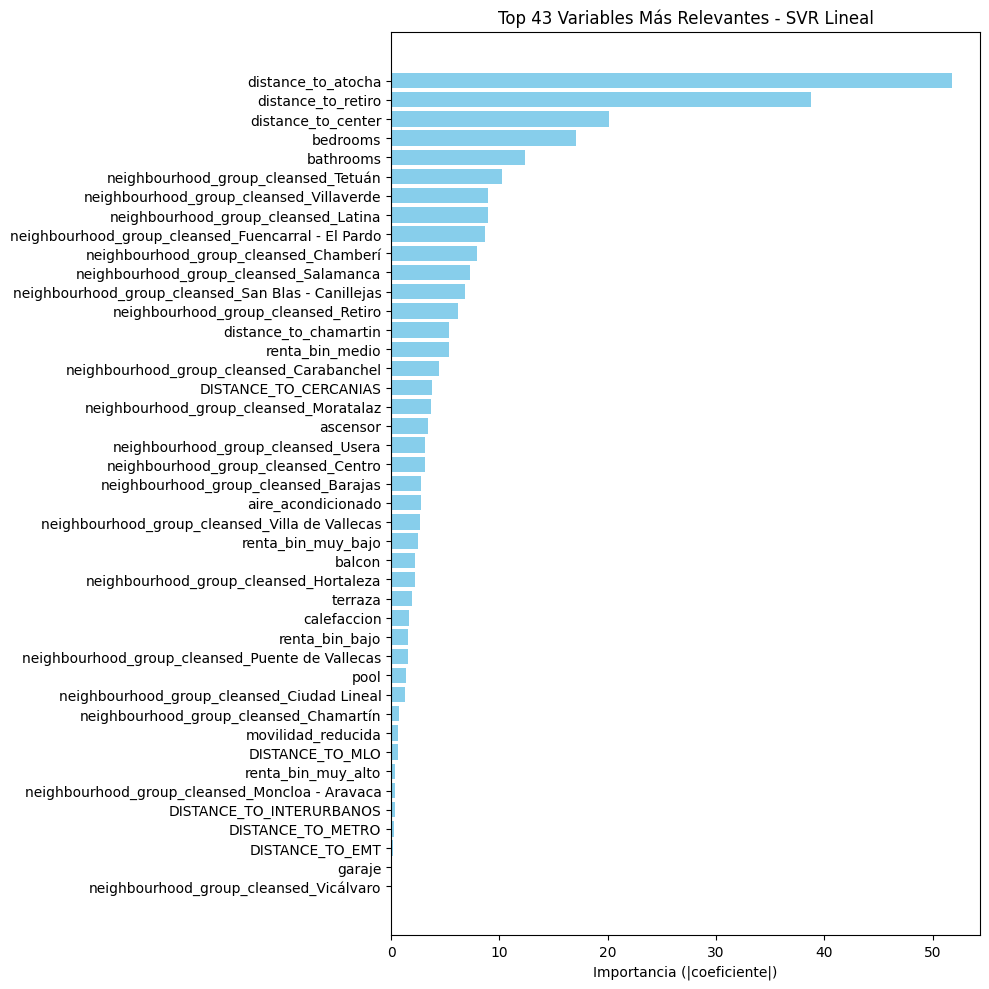

In [51]:
# Extraer los coeficientes absolutos
coeficientes = np.abs(model_SVR.named_steps['regressor'].coef_[0])

# Asociar coeficientes con nombres de variables
importancias_df = pd.DataFrame({
    'Variable': all_feature_names,
    'Importancia': coeficientes
}).sort_values(by='Importancia', ascending=False)

# Opcional: filtrar top N variables más importantes
top_n = 43
importancias_top = importancias_df.head(top_n)

# Graficar
plt.figure(figsize=(10, 10))
plt.barh(importancias_top['Variable'], importancias_top['Importancia'], color='skyblue')
plt.gca().invert_yaxis()  # Las más importantes arriba
plt.xlabel('Importancia (|coeficiente|)')
plt.title(f'Top {top_n} Variables Más Relevantes - SVR Lineal')
plt.tight_layout()
plt.show()

Aunque las predicciones puedan variar un poco con respecto a la primera iteración, en esencia sigue la misma lógica y se obtienen las mismas conclusiones. Por lo que no repetiremos las mismas conclusiones que las descritas al final del __Modelo 1__.